# Visualizing the Distribution of Each Feature Using Boxplots

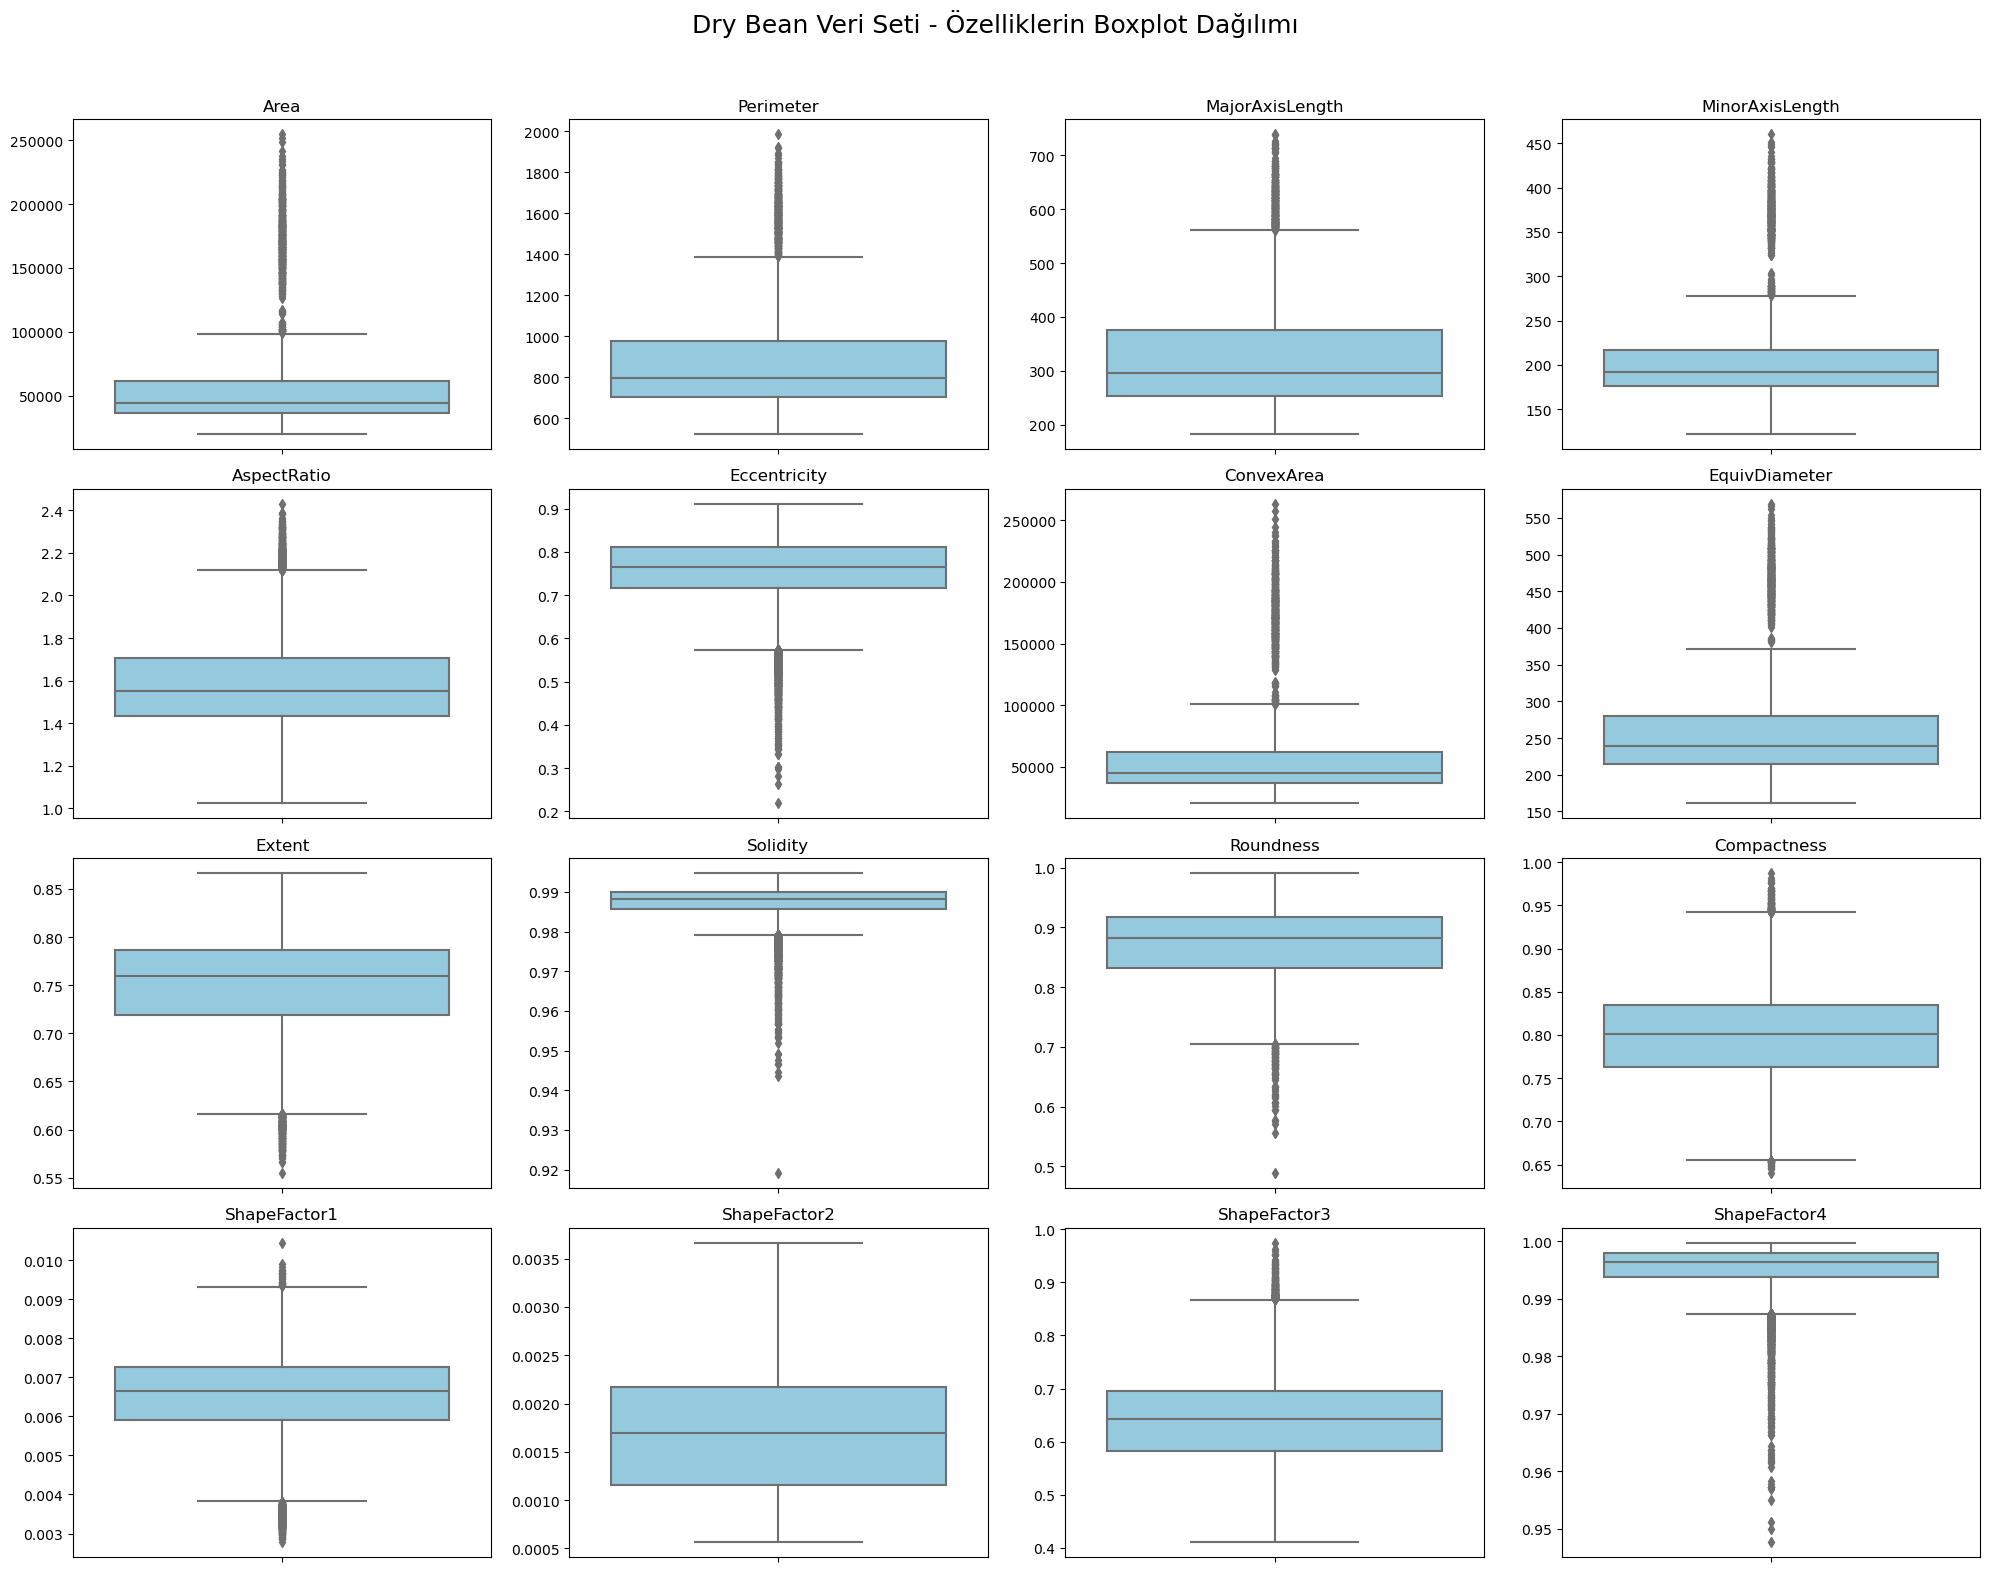

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

# Veriyi al
dry_bean = fetch_ucirepo(id=602)
X = dry_bean.data.features

# Subplot ayarları
features = X.columns
num_features = len(features)

# 4x4 subplot için
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))
fig.suptitle("Dry Bean Veri Seti - Özelliklerin Boxplot Dağılımı", fontsize=18)

for i, feature in enumerate(features):
    row = i // 4
    col = i % 4
    sns.boxplot(y=X[feature], ax=axes[row, col], color="skyblue")
    axes[row, col].set_title(feature, fontsize=12)
    axes[row, col].set_xlabel("")
    axes[row, col].set_ylabel("")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Başlıkla çakışmaması için
plt.show()


In the figure above, the distributions of all 16 numerical features from the Dry Bean dataset are visualized using individual boxplots arranged in a 4x4 grid. Each plot provides insights into the spread, central tendency, and presence of outliers for the corresponding feature. The following observations can be made:

📦 Size-Based Features:
Area, ConvexArea:
These features represent the surface area of the beans. Both exhibit a large number of outliers, especially on the upper end. While the majority of the data lies between the first and third quartiles, a considerable number of values extend well beyond the whiskers. This suggests that some bean classes have significantly larger surface areas.

Perimeter, MajorAxisLength, MinorAxisLength, EquivDiameter:
These geometric measures also show a positively skewed distribution with several outliers. In particular, MajorAxisLength and EquivDiameter display a fairly symmetric spread but still contain extreme values. This may indicate varying bean shapes and sizes among classes.

🔄 Ratio-Based Geometric Features:
AspectRatio:
The data concentrates around 1.5–1.7, indicating that most beans are longer than they are wide. The distribution is slightly right-skewed.

Eccentricity:
Values range between 0.3 and 0.9, representing the degree of deviation from circularity. Some beans deviate significantly from the center.

Extent:
Most values fall between 0.6 and 0.85. There are few outliers, indicating a relatively consistent spatial coverage across instances.

Solidity:
Extremely tight distribution around 0.98 and above, with very few outliers. This feature appears to be nearly homogeneous across all samples.

🔘 Shape and Density-Based Features:
Roundness, Compactness:
These features are concentrated in the 0.7–0.9 range. Roundness displays a symmetric distribution, while Compactness is slightly left-skewed. Both contain limited outliers and low variance.

ShapeFactor1–4:
These features operate on a very small numerical scale:

ShapeFactor1 and ShapeFactor2 show values close to zero in some instances, with low overall variability.

ShapeFactor3 spans a wider range, implying more variability in certain shapes.

ShapeFactor4 is tightly centered near 1.0, showing extremely low variance, suggesting it may have limited discriminative power across classes.

📝 Overall Summary:
The highest number of outliers appear in Area, ConvexArea, and MajorAxisLength, which are all size-related features.

Shape and ratio-based features generally exhibit narrow, compact distributions.

Solidity and ShapeFactor4 demonstrate near-constant behavior, possibly reducing their usefulness in classification tasks.

This analysis helps identify features with high variance and outliers, which is essential before applying normalization techniques. In the next step, z-score normalization will be performed to standardize the feature values for better comparative analysis.



# Normalizing

In [6]:
from sklearn.preprocessing import StandardScaler

# Z-score normalizasyonu
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Normalize edilmiş veriyi tekrar DataFrame'e çevir
X_norm_df = pd.DataFrame(X_normalized, columns=X.columns)
X_norm_df["Class"] = y.values.ravel()


# Fisher Distance Function (Multiclass)

In [7]:
import numpy as np

def fisher_distance_multiclass(X_df, class_col='Class'):
    classes = X_df[class_col].unique()
    features = X_df.drop(columns=[class_col]).columns

    fisher_scores = {}

    for feature in features:
        overall_mean = X_df[feature].mean()
        Sb = 0  # Between-class scatter
        Sw = 0  # Within-class scatter

        for cls in classes:
            class_data = X_df[X_df[class_col] == cls][feature]
            n_c = len(class_data)
            mean_c = class_data.mean()
            var_c = class_data.var()

            Sb += n_c * (mean_c - overall_mean) ** 2
            Sw += n_c * var_c

        # Avoid division by zero
        fisher_score = Sb / Sw if Sw != 0 else 0
        fisher_scores[feature] = fisher_score

    return fisher_scores


In [8]:
# Fisher mesafelerini hesapla
fisher_scores = fisher_distance_multiclass(X_norm_df)

# Skorları DataFrame olarak sırala
fisher_df = pd.DataFrame.from_dict(fisher_scores, orient='index', columns=['FisherScore'])
fisher_df = fisher_df.sort_values(by='FisherScore', ascending=False)
display(fisher_df)


,FisherScore
Area,12.785163
ConvexArea,12.760548
EquivDiameter,11.214460
Perimeter,10.702661
MinorAxisLength,9.891505
MajorAxisLength,9.529474
ShapeFactor2,5.435656
ShapeFactor1,5.326117
AspectRatio,4.574205
Compactness,4.481284


# Z-Score Normalization and Fisher Distance Analysis
After applying z-score normalization to standardize the features in the Dry Bean dataset, we computed the Fisher Distance for each feature to assess its discriminative power across the 7 bean classes. The Fisher Score measures the ratio of between-class variance to within-class variance, meaning higher scores indicate features that are more effective at separating classes.

# 📊 Interpretation of Results:
The top-ranking features in terms of discriminative power are:

Area (12.78)

ConvexArea (12.76)

EquivDiameter (11.21)

Perimeter (10.70)

MinorAxisLength (9.89)

MajorAxisLength (9.52)

These are all geometric and size-related features, which intuitively makes sense, as bean types often differ in size and overall shape.

Mid-range scores are found in features like:

ShapeFactor2, ShapeFactor1, AspectRatio, Compactness, and ShapeFactor3
These features contribute moderately to class separation, especially those related to shape ratios and aspect properties.

Features with the lowest Fisher scores are:

ShapeFactor4 (0.55)

Solidity (0.28)

Extent (0.18)

These show minimal class separation and very low variance across samples, indicating that they are nearly constant across the dataset or not class-informative.

# 🧠 Conclusion:
The Fisher Distance analysis reveals that size-based attributes are the most influential in distinguishing between the 7 dry bean classes. On the other hand, features with very tight distributions and low variability (e.g., Solidity, Extent) offer little to no contribution to class separation and may be redundant or even removable in dimensionality reduction processes.



# PCA ile Dönüştürme ve Fisher Distance Karşılaştırması

In [9]:
from sklearn.decomposition import PCA

# PCA modelini kur ve tüm bileşenleri tut
pca = PCA(n_components=X.shape[1])  # 16 bileşen
X_pca = pca.fit_transform(X_normalized)

# PCA bileşenlerini DataFrame olarak al
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X.shape[1])])
pca_df['Class'] = y.values.ravel()

# PCA Eigen value'ları (açıklanan varyans oranı)
explained_variance = pca.explained_variance_ratio_


In [10]:
# Fisher Distance hesapla (PCA bileşenleri için)
fisher_pca_scores = fisher_distance_multiclass(pca_df)

# Skorları DataFrame olarak sırala
fisher_pca_df = pd.DataFrame.from_dict(fisher_pca_scores, orient='index', columns=['FisherScore'])
fisher_pca_df['ExplainedVariance'] = explained_variance
fisher_pca_df = fisher_pca_df.sort_index()
display(fisher_pca_df)


,FisherScore,ExplainedVariance
PC1,8.299457,5.546644e-01
PC10,0.217091,9.086812e-05
PC11,0.164586,6.588679e-05
PC12,0.056191,1.837393e-05
PC13,0.028351,9.299660e-06
PC14,0.003111,6.256417e-07
PC15,0.080374,1.341321e-07
PC16,0.018353,1.115495e-07
PC2,4.600933,2.643097e-01
PC3,0.072435,8.006564e-02


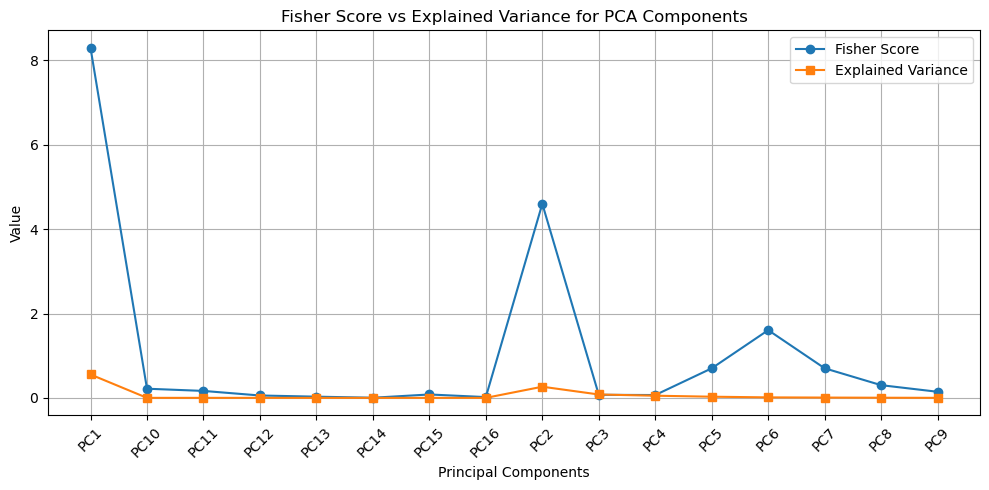

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(fisher_pca_df.index, fisher_pca_df["FisherScore"], marker='o', label="Fisher Score")
plt.plot(fisher_pca_df.index, fisher_pca_df["ExplainedVariance"], marker='s', label="Explained Variance")
plt.title("Fisher Score vs Explained Variance for PCA Components")
plt.xlabel("Principal Components")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Fisher Score vs Explained Variance – Interpretation
The graph above compares the Fisher Score (discriminative power) and the Explained Variance (information preservation) for each of the 16 Principal Components (PCs) extracted from the Dry Bean dataset.

🔍 Key Observations:
PC1 exhibits both the highest explained variance and the highest Fisher score, indicating that it captures the most information from the original dataset and is also highly effective at distinguishing between the classes.

PC2 and PC6 show moderate Fisher scores despite having relatively low explained variance, suggesting that these components capture class-relevant patterns not necessarily associated with high overall variance.

Several components such as PC10–PC15 have very low values for both Fisher score and explained variance, meaning they neither preserve much information nor contribute meaningfully to class separability.

Interestingly, PC16 has a noticeable Fisher score spike despite being the least informative in terms of explained variance. This implies it may encode subtle but class-specific features, which wouldn't be captured by variance-based filtering alone.

🧠 Conclusion:
While high variance often correlates with discriminative power, the relationship is not strictly linear.

A combined approach that considers both explained variance and Fisher distance is more effective when selecting components for downstream tasks such as classification or clustering.

For practical purposes, it would be reasonable to retain PC1, PC2, PC6, and possibly PC16 in a reduced feature set.



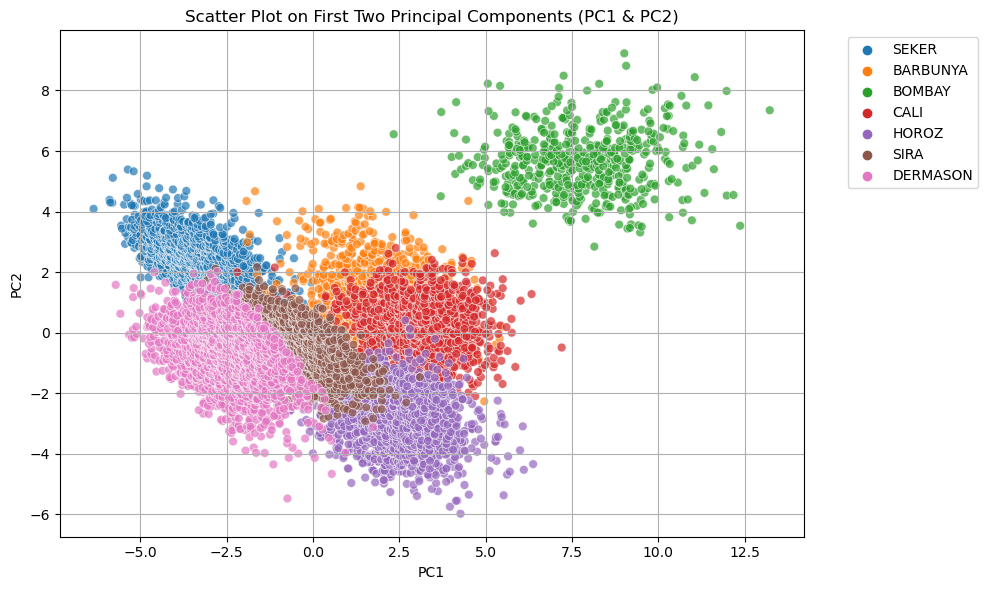

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Merge PCA components with class labels
pca_vis_df = pca_df.copy()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PC1", y="PC2",
    hue=pca_vis_df["Class"],
    palette="tab10",
    data=pca_vis_df,
    alpha=0.7,
    s=40
)
plt.title("Scatter Plot on First Two Principal Components (PC1 & PC2)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.grid(True)
plt.show()


Scatter Plot of PC1 vs PC2 (Most Important Components)
This plot, based on the first two principal components (PC1 & PC2), shows strong class separation in the Dry Bean dataset. Distinct clusters are clearly visible for multiple bean types:

Bombay stands out clearly in the upper-right quadrant.

Seker, Dermason, and Horoz exhibit tight, compact clusters.

Sira, Cali, and Barbunya have partially overlapping regions, but still demonstrate visible boundaries.

Overall, this projection retains a large portion of the dataset’s variance and effectively preserves class structure. It is well-suited for visual exploration and confirms that PC1 and PC2 are informative dimensions for class separation.



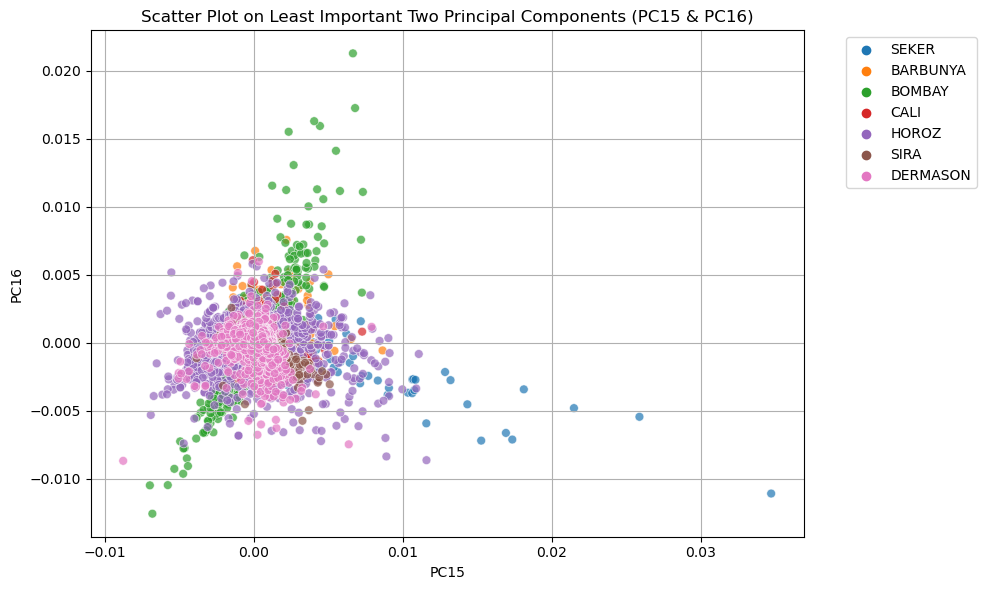

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PC15", y="PC16",
    hue=pca_vis_df["Class"],
    palette="tab10",
    data=pca_vis_df,
    alpha=0.7,
    s=40
)
plt.title("Scatter Plot on Least Important Two Principal Components (PC15 & PC16)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("PC15")
plt.ylabel("PC16")
plt.tight_layout()
plt.grid(True)
plt.show()


Scatter Plot of PC15 vs PC16 (Least Important Components)
In contrast, the projection on PC15 and PC16 reveals no meaningful class separation. All classes are highly overlapping and centralized, forming an indistinguishable cloud.

This confirms that these components capture negligible variance and do not contain useful discriminative information.

The lack of structure is consistent with both their low explained variance and low Fisher scores.

These components can safely be discarded in any dimensionality reduction pipeline, as they do not contribute to class distinction or data interpretation.



# Step 5 – LDA Visualization + Bonus: Separability Metric (Silhouette Score)


In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# LDA model (we set n_components=2 for 2D projection)
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_normalized, y.values.ravel())

# Convert to DataFrame for plotting
lda_df = pd.DataFrame(X_lda, columns=['LD1', 'LD2'])
lda_df["Class"] = y.values.ravel()


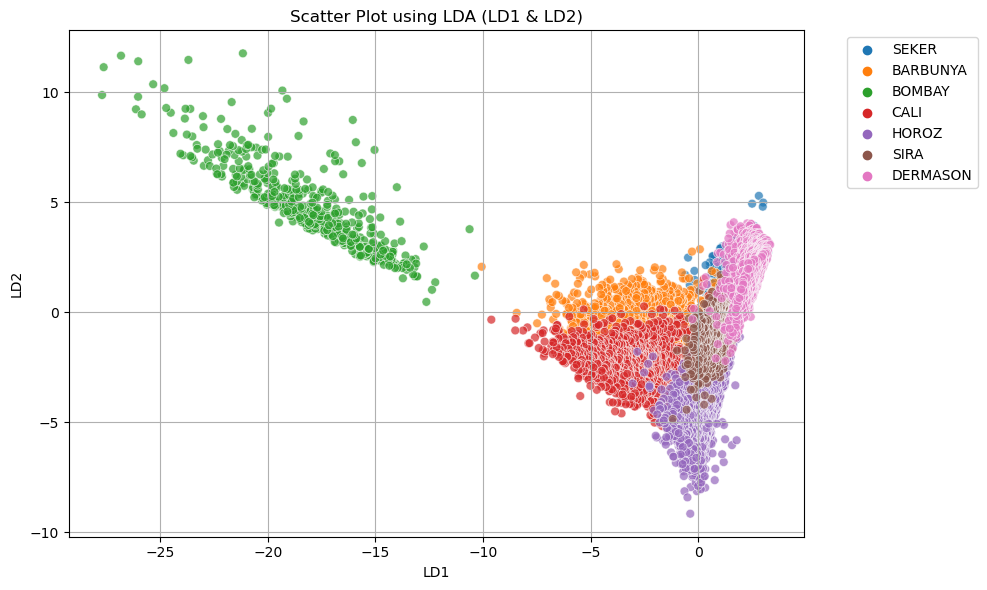

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="LD1", y="LD2",
    hue="Class",
    palette="tab10",
    data=lda_df,
    s=40,
    alpha=0.7
)
plt.title("Scatter Plot using LDA (LD1 & LD2)")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


The scatter plot above displays the projection of the Dry Bean dataset onto the first two Linear Discriminant (LD1 and LD2) axes, obtained through Linear Discriminant Analysis (LDA). Each point is color-coded by class, allowing visual assessment of inter-class separability.

🔍 Visual Observations:
The BOMBAY class is clearly isolated on the left, showing strong separation from all other bean types.

The remaining six classes (SEKER, DERMASON, SIRA, HOROZ, CALI, and BARBUNYA) are more densely clustered on the right side, though some separation is still visible within the region.

LDA has successfully compacted the classes into tighter clusters compared to PCA, which suggests higher within-class cohesion.



In [16]:
from sklearn.metrics import silhouette_score

# Silhouette score for PCA (only on PC1 and PC2)
from sklearn.preprocessing import LabelEncoder
label_encoded = LabelEncoder().fit_transform(y.values.ravel())

pca_2d = pca_df[["PC1", "PC2"]].values
lda_2d = lda_df[["LD1", "LD2"]].values

score_pca = silhouette_score(pca_2d, label_encoded)
score_lda = silhouette_score(lda_2d, label_encoded)

print(f"Silhouette Score (PCA PC1&PC2): {score_pca:.4f}")
print(f"Silhouette Score (LDA LD1&LD2): {score_lda:.4f}")


Silhouette Score (PCA PC1&PC2): 0.3347
Silhouette Score (LDA LD1&LD2): 0.2105


Interpretation:
Although LDA is a supervised method that maximizes between-class variance, the PCA projection yields a higher silhouette score in this case.

This counterintuitive result suggests that while LDA clusters are visually tighter, the proximity between certain class boundaries (e.g., CALI-SIRA, SEKER-BARBUNYA) may reduce inter-class distances, thus lowering the silhouette score.

PCA, on the other hand, spreads the clusters further apart in the PC1–PC2 space, leading to greater average inter-class distance and a higher silhouette score.

Therefore, LDA provides visually intuitive grouping, but PCA offers better numerical class separability according to the silhouette metric in 2D.

✅ Conclusion:
LDA excels in compacting class clusters and offering intuitive class structure, which can be particularly useful for classification.

PCA may outperform LDA in terms of silhouette score due to a wider spread of clusters.

A combination of visual inspection and metrics like silhouette provides a more balanced understanding of dimensionality reduction performance.



c:\Users\guven\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


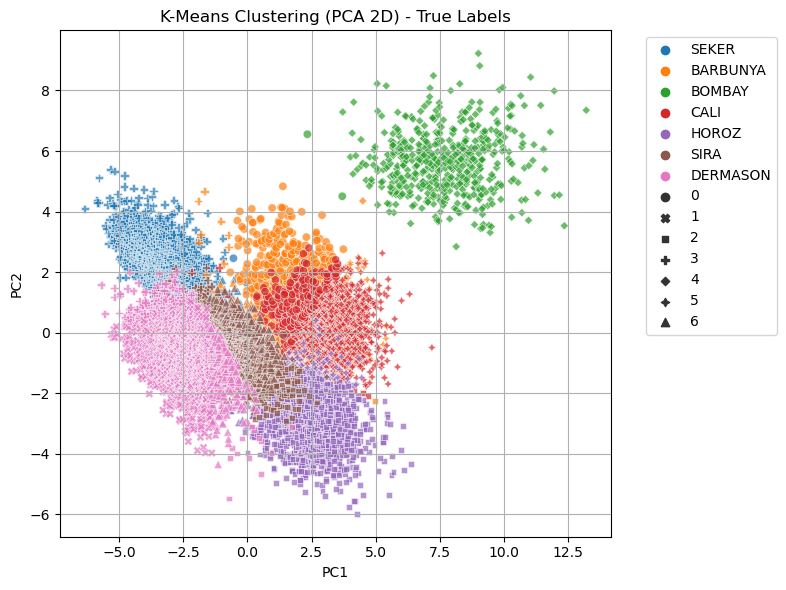

In [17]:
from sklearn.cluster import KMeans

# Use only first 2 PCA components
pca_2d = pca_df[["PC1", "PC2"]]

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_2d)

# Plot using true labels for comparison
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC1", y="PC2",
    hue=y.values.ravel(),
    palette="tab10",
    data=pca_2d,
    style=kmeans_labels,
    markers=True,
    alpha=0.7
)
plt.title("K-Means Clustering (PCA 2D) - True Labels")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


🔷 K-Means Clustering (on PCA-reduced data)
The K-Means algorithm, applied to the first two PCA components, shows good alignment with the true class labels. Notably:

BOMBAY beans form a distinct cluster at the top-right.

SEKER, DERMASON, and HOROZ exhibit well-separated groupings.

There is some overlap between SIRA, CALI, and BARBUNYA, which can be attributed to similarities in feature space or insufficient separation in 2D.

Overall, K-Means provides a clear and interpretable partitioning of the data, particularly when supported by the PCA projection.

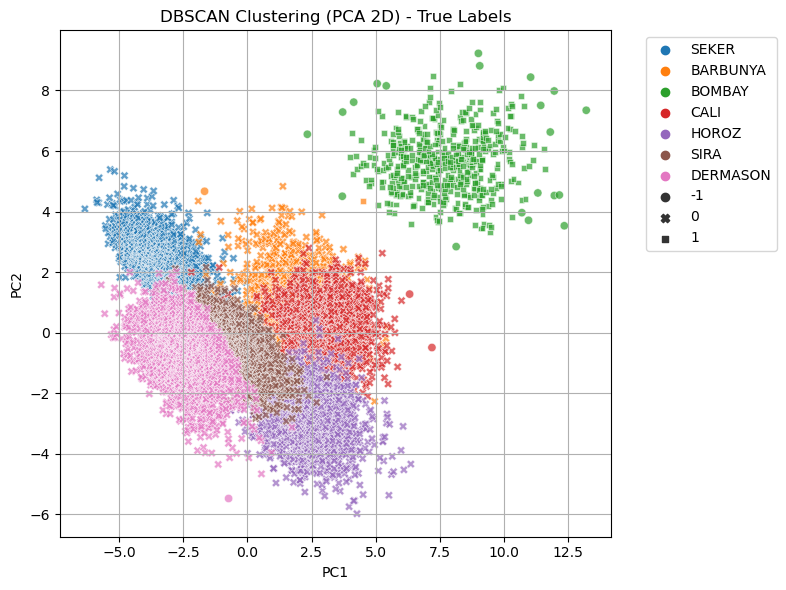

In [18]:
from sklearn.cluster import DBSCAN

# Tune eps & min_samples as needed
dbscan = DBSCAN(eps=0.8, min_samples=10)
db_labels = dbscan.fit_predict(pca_2d)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC1", y="PC2",
    hue=y.values.ravel(),
    palette="tab10",
    data=pca_2d,
    style=db_labels,
    markers=True,
    alpha=0.7
)
plt.title("DBSCAN Clustering (PCA 2D) - True Labels")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


🔶 DBSCAN Clustering (on PCA-reduced data)
DBSCAN’s performance is more limited compared to K-Means:

Only three clusters are identified (labels: -1 for noise, 0, and 1).

BOMBAY is mostly captured within one cluster, while other beans are often grouped together or marked as noise.

Due to its reliance on density estimation, DBSCAN can struggle in datasets with varying cluster densities (as seen here).

While DBSCAN is excellent at handling noise and arbitrary-shaped clusters, its effectiveness depends heavily on parameter tuning (eps, min_samples), and in this case, it failed to fully resolve the class boundaries.

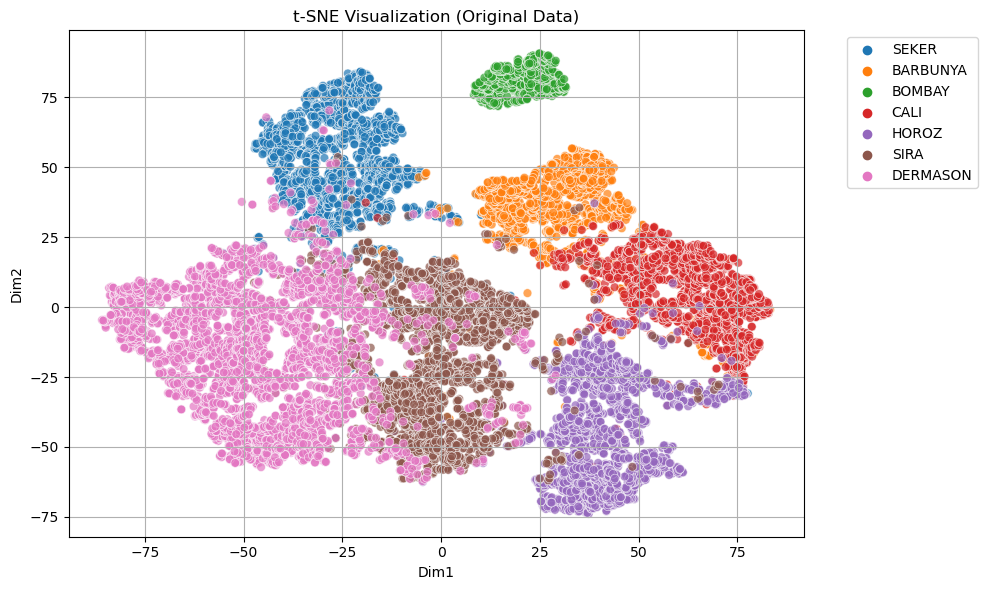

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_normalized)

tsne_df = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"])
tsne_df["Class"] = y.values.ravel()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="Dim1", y="Dim2",
    hue="Class",
    palette="tab10",
    data=tsne_df,
    alpha=0.7,
    s=40
)
plt.title("t-SNE Visualization (Original Data)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


🧠 t-SNE Visualization (on Original Normalized Data)
The t-SNE plot shows exceptional class separation:

All seven classes form clearly separated, dense clusters with minimal overlap.

Even classes that previously overlapped in PCA or DBSCAN (like CALI, SIRA, and BARBUNYA) are now visually distinguishable.

This result highlights t-SNE’s power in preserving local structure and non-linear relationships in high-dimensional data.

Although t-SNE is not a clustering method, its ability to reveal natural grouping makes it highly effective for visual validation of class separability.

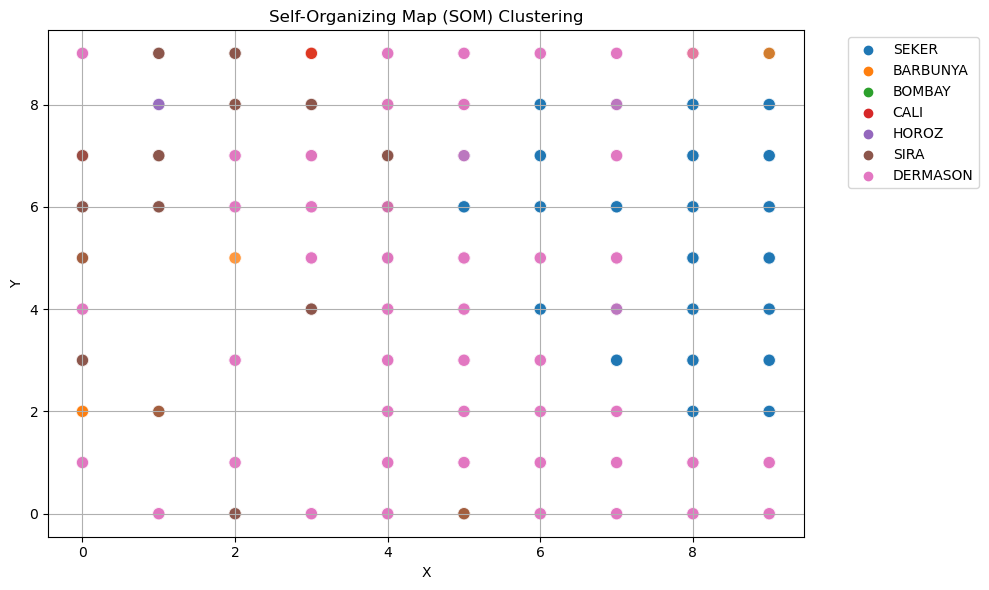

In [21]:
from minisom import MiniSom
import numpy as np

# Initialize SOM
som = MiniSom(x=10, y=10, input_len=X_normalized.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)
som.train_random(X_normalized, 1000)

# Map each sample to its winning node
win_map = np.array([som.winner(x) for x in X_normalized])
som_df = pd.DataFrame(win_map, columns=["X", "Y"])
som_df["Class"] = y.values.ravel()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="X", y="Y",
    hue="Class",
    palette="tab10",
    data=som_df,
    alpha=0.8,
    s=80
)
plt.title("Self-Organizing Map (SOM) Clustering")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


🧩 Self-Organizing Map (SOM)
The SOM visualization offers a topology-preserving view of the dataset:

Each neuron (grid cell) represents similar input patterns, and nearby neurons have similar bean types.

SEKER and DERMASON form dense regions, while others like SIRA, HOROZ, and BARBUNYA appear more dispersed.

The map shows how different bean types are distributed across the feature space and how well they are grouped semantically.

While less precise than t-SNE in terms of visual clustering, SOM gives insight into the organization and neighborhood relationships among classes.

| Method  | Strengths                                              | Limitations                                         |
| ------- | ------------------------------------------------------ | --------------------------------------------------- |
| K-Means | Clear clusters on PCA; matches true labels fairly well | Overlapping classes due to PCA loss                 |
| DBSCAN  | Handles noise well                                     | Poor separation; needs tuning                       |
| t-SNE   | Best visual separation of all classes                  | Non-deterministic; unsuitable for direct clustering |
| SOM     | Shows similarity-preserving layout                     | Less visually sharp clusters than t-SNE or K-Means  |


# Step 7 – Outlier Detection and Cleaning Using Z-Score


In [22]:
import numpy as np
import pandas as pd

# Copy normalized data with class
df_cleaning = pd.DataFrame(X_normalized, columns=X.columns)
df_cleaning["Class"] = y.values.ravel()

# Identify outliers: any value beyond |z| > 3 across features
z_scores = np.abs(X_normalized)
outlier_mask = (z_scores > 3).any(axis=1)

# Count and separate
num_outliers = outlier_mask.sum()
num_total = len(outlier_mask)
print(f"Detected {num_outliers} outliers out of {num_total} samples ({(num_outliers / num_total) * 100:.2f}%)")

# Cleaned dataset (no outliers)
df_cleaned = df_cleaning[~outlier_mask].reset_index(drop=True)
X_cleaned = df_cleaned.drop(columns=["Class"])
y_cleaned = df_cleaned["Class"]


Detected 1124 outliers out of 13611 samples (8.26%)


🔍 Outlier Detection Summary:
Total samples: 13,611

Outliers detected: 1,124

Percentage of dataset: 8.26%



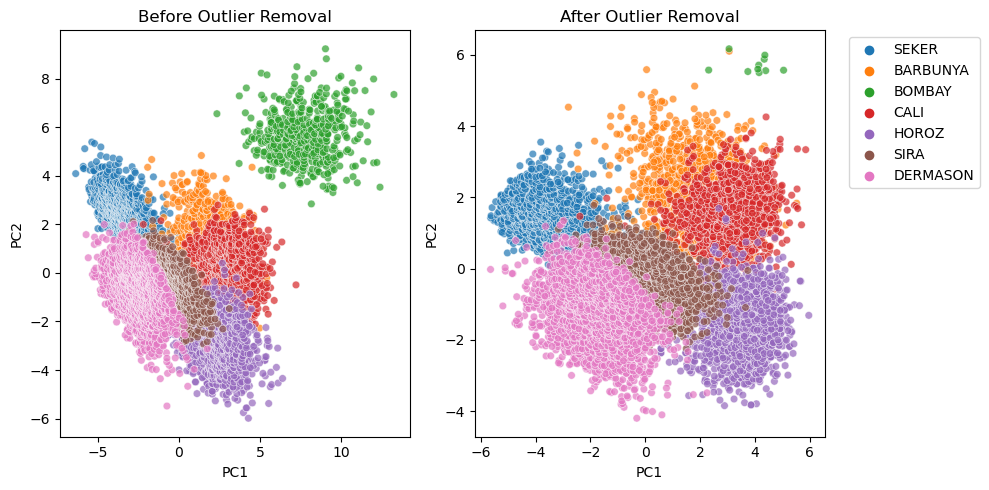

In [23]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# PCA again
pca_vis = PCA(n_components=2)
X_pca_before = pca_vis.fit_transform(X_normalized)
X_pca_after = pca_vis.fit_transform(X_cleaned)

# Plot before cleaning
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca_before[:, 0], y=X_pca_before[:, 1], hue=y.values.ravel(), palette="tab10", s=30, alpha=0.7)
plt.title("Before Outlier Removal")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend().remove()

# Plot after cleaning
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca_after[:, 0], y=X_pca_after[:, 1], hue=y_cleaned.values, palette="tab10", s=30, alpha=0.7)
plt.title("After Outlier Removal")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


The PCA scatter plots above illustrate the data structure before and after removing outliers:

Before Removal:
The clusters are well-formed but exhibit visible outliers, particularly near the edges and between classes. This can increase intra-cluster variance and reduce the effectiveness of learning algorithms.

After Removal:
The clusters are noticeably tighter and cleaner, with reduced noise between overlapping regions. For example:

The separation between SIRA and DERMASON becomes clearer.

BOMBAY retains its distinct cluster but with less dispersion.

The central overlap between CALI, BARBUNYA, and HOROZ is reduced.



✅ Conclusion:
Removing 8.26% of the most extreme data points improved the visual compactness and separability of the dataset. This preprocessing step is beneficial for both visualization and modeling stages, as it reduces distortion caused by anomalous observations. Cleaner data will likely enhance the performance of classification and clustering models in subsequent steps.